# Introduction to RNNs with Keras
## IADS Summer School, 3rd August 2021

### Dr Michael Fairbank, University of Essex, UK

- Email: m.fairbank@essex.ac.uk
- This is Jupyter Notebook 2.1 of the course

## Introducing Recurrent Neural Networks (RNNs)

A recurrent neural network is a graph with *cycles* in it, i.e.
a network with *one or more backward-linking connections*.

- A very simple example is:

<img src="./images/rnn_mike.svg" alt="A basic RNN" width="400">

- They are built for processing *time sequences* of data, $\{x_t\}$ for $t=0,1,\ldots, T-1$.

We will build a RNN of the above type this in this notebook.

## A simple Time-Sequence Problem

- The challenge is to train a RNN to find the maximum and minimum of a list of numbers.

- So for example, given the list of numbers "3.1,**-2.1**,**4.0**,2.5,1.0",
- the RNN must learn to output "Max=4.0, Min=-2.1".

- Note that we consider this list "3.1,-2.1,4.0,2.5,1.0" to be a *time-sequence*.

We can generate some training data of this kind using the following script:

In [1]:
import numpy as np

time_sequence_length=4
training_set_size=10000
x_train=np.random.rand(training_set_size,time_sequence_length) # builds a matrix of random floats in [0,1)
x_train=x_train*2-1 # rescales numbers to be between -1 and +1
x_train=x_train*(np.random.rand(training_set_size,1)+0.5) # rescales each row so each row has a different range.  Uses broadcasting to make this multiplication work.
x_train=x_train+(np.random.rand(training_set_size,1)*2-1) # shifts the mean of each row. Uses broadcasting.
y_train=np.stack([np.max(x_train, axis=1),np.min(x_train, axis=1)],axis=1) # This finds the maximum of each row.

- We can check these numpy arrays are doing what they should.  First print sample 0 and its labels:

In [2]:
print("x_train, sample 0",x_train[0]) # This is the first training list of numbers
print("y_train, sample 0",y_train[0]) # This should show the max and min

x_train, sample 0 [-0.96337219 -1.2966338  -0.49473392 -0.30402367]
y_train, sample 0 [-0.30402367 -1.2966338 ]


Hopefully we can see that the y values are the max and min of the corresponding list of x-values.

- Then see another training sample:

In [3]:
print("x_train, sample 1",x_train[1]) # This is the next training list of numbers
print("y_train, sample 1",y_train[1]) # This should show the max and min

x_train, sample 1 [ 0.10604646 -0.89791785 -0.53902545 -0.6592522 ]
y_train, sample 1 [ 0.10604646 -0.89791785]


## Understanding The Shape of Input Tensors for RNN time Sequences

- We have created 10000 time sequences, each with 4 time steps
- where each step provides exactly 1 scalar input.  Hence we set:
   - training_set_size=10000,
   - time_sequence_length=4,
   - input_vector_length=1

- RNNs in Keras expect time sequences to be rank-3 tensors,
of shape [training_set_size, time_sequence_length, input_vector_length], as follows:


In [4]:
input_vector_length=1
x_train=x_train.reshape(training_set_size,time_sequence_length,input_vector_length).astype(np.float32)
print(x_train.shape)

(10000, 4, 1)


We've defined the input shape for this time sequence.
Next we look at the target-output sequence:

- This RNN will only make an output once, after the final time step has been inputted.
-  Hence it is called a "Many-to-one RNN".

- When the output does come, it will have output_vector_length=2.

In [5]:
output_vector_length=2 
y_train=y_train.reshape(training_set_size,output_vector_length).astype(np.float32)
print(y_train.shape)

(10000, 2)


## Build a RNN to process this input tensor

We now use Keras to build a recurrent neural network to process a time sequence.
<img src="./images/rnn_mike.svg" alt="A basic RNN" width="300">

The time sequence must be a rank-3 tensor (3-dimensional array): 

1. The first dimension is the batch.
2. The second is the time sequence length.
3. The third is the number of inputs per time step of the sequence.

So the shape is [batch, time_sequence_length, num_inputs_per_timestep]

- The following code allows us to hand build a RNN that takes the sequence of inputs, and loops around it multiplying it by the appropriate weight matrices, and finally spitting out a single output vector (for each training pattern).  

- This way of defining the model is more flexible than the previous "Sequential" models we built before.   See [Custom Layers and Models](https://www.tensorflow.org/guide/keras/custom_layers_and_models) for further information.

-  The main model runs through the "call" function, which takes a rank-3 tensor input, and returns the rank-2 output tensor. 

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
class HandBuiltRNNModel(keras.Model):
    def __init__(self, num_hidden_nodes, num_outputs):
        super(HandBuiltRNNModel, self).__init__()
        #build layers here, and store as class (instance) variables
        self.num_hidden_nodes=num_hidden_nodes
        self.main_layer=layers.Dense(self.num_hidden_nodes,activation="tanh")
        self.output_layer=layers.Dense(num_outputs)
        
    def call(self, inputs):
        # on entry, inputs should be a rank-3 tensor of shape [batch_size, time_sequence_length, input_vector_length]
        x=inputs
        batch_size=inputs.shape[0]
        hidden_recurrent_state=tf.fill([batch_size, self.num_hidden_nodes], 0.0)
        for t in range(time_sequence_length):
            input_t=inputs[:,t,:] # This extracts one slice of the rank-3 inputs tensor, resulting in a rank-2 tensor
            # The next line concatenates 2 rank-2 tensors (side-by-side) into one large tensor
            x=tf.concat([input_t,hidden_recurrent_state],axis=1)
            hidden_recurrent_state=self.main_layer(x)
        # Now hidden_recurrent_state is of shape [batch_size, num_hidden_nodes]
        output_tensor=self.output_layer(hidden_recurrent_state)
        return output_tensor # this will be of shape [batch_size, output_vector_length]
        
model_handbuilt_rnn = HandBuiltRNNModel(num_hidden_nodes=20, num_outputs=output_vector_length)

This hand-built model consumes a tensor of shape \[training_set_size,time_sequence_length,input_vector_length\] and outputs one of shape \[training_set_size,output_vector_length\]


In [7]:
# Try putting a single input into the network
print(model_handbuilt_rnn(x_train[0:1,:,:]))

tf.Tensor([[ 0.03333271 -0.44526616]], shape=(1, 2), dtype=float32)


In [8]:
# Try putting a "batch" of 2 input vectors through the network
print(model_handbuilt_rnn(x_train[0:2,:,:]))

tf.Tensor(
[[ 0.03333266 -0.44526607]
 [-0.0840024  -0.71692735]], shape=(2, 2), dtype=float32)


**Questions:**

1. What are the shapes of the tensors x_train[0:1,:,:], x_train[0:2,:,:], x_train[0,:,:]?

2. Write some code below to print out these 3 shapes. 

In [9]:
# TODO insert code here

To visualise what the network is doing over whole dataset, we'll try the following scatter plot.

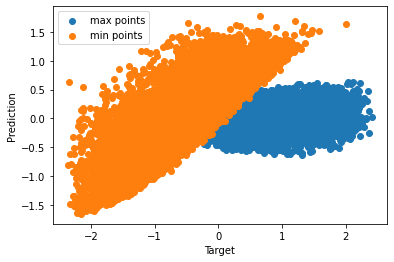

In [10]:
# Let's plot the model's current behaviour:
import matplotlib.pyplot as plt
plt.scatter(y_train[:,0],model_handbuilt_rnn(x_train).numpy()[:,0],label="max points")
plt.scatter(y_train[:,1],model_handbuilt_rnn(x_train).numpy()[:,1],label="min points")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend()


- If the RNN is doing what it should then the scatter points should line up on the line $y=x$.

- Of course, it's not trained yet, so the points don't line up at all yet!

The above graph shows the neural network is not doing what we want it to yet, because we've just built our network with entirely random weights.  

## Training the neural network

So next we'll "train" the network, i.e. change the values of its weights so that its outputs match the target curve.

Again we use gradient descent, with the gradients computed for us by TensorFlow's automatic-differentiation, using the Keras "fit" loop.

#### Back-propagation through time (BPTT)
- To compute the necessary derivatives here, we would have to imagine unrolling the recurrent loop "through time", making a very long unrolled network. 

<img src="./images/rnn_unroll.svg" alt="Showing a RNN unrolled through time" width="700">

- The unrolled network looks like a feed-forward network.
- We  can differentiate carefully step-by-step going backwards through this large unrolled network ("back-propagating" derivatives again)
    - This gradient-finding technique of differentation is known as "back-propagation through time" (BPTT).  
    - This is all handled internally by Tensforflow and Keras for us.
    

So we'll use the usual Keras compile and fit method:
    

In [11]:
model_handbuilt_rnn.compile(
    optimizer=keras.optimizers.Adam(0.01),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()],
)

In [12]:
history_handbuilt = model_handbuilt_rnn.fit(
    x_train,
    y_train,
    batch_size=100,
    epochs=30
)

Epoch 1/30
100/100 [==============================] - 0s 809us/step - loss: 0.1135 - mean_absolute_error: 0.2637
Epoch 2/30
100/100 [==============================] - 0s 843us/step - loss: 0.0928 - mean_absolute_error: 0.2435
Epoch 3/30
100/100 [==============================] - 0s 797us/step - loss: 0.0895 - mean_absolute_error: 0.2385
Epoch 4/30
100/100 [==============================] - 0s 766us/step - loss: 0.0439 - mean_absolute_error: 0

- Now the network is trained, the scatter plot should line up nicely along $y=x$...

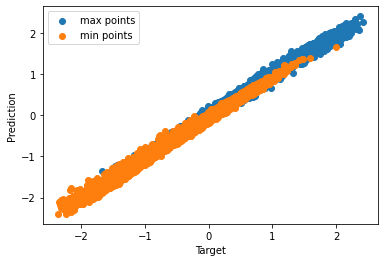

In [13]:
# Let's plot the model's current behaviour:
plt.scatter(y_train[:,0],model_handbuilt_rnn(x_train).numpy()[:,0],label="max points")
plt.scatter(y_train[:,1],model_handbuilt_rnn(x_train).numpy()[:,1],label="min points")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend()

 - These points are starting to line up nicely!
 - We could re-run the previous 3 cells again to train the network a bit more.  
 

In [14]:
# Try putting a single input into the network
print(model_handbuilt_rnn(x_train[0:1,:,:]))
# And compare to the target min/max output
print(y_train[0:1,:])

tf.Tensor([[-0.2999265 -1.3113838]], shape=(1, 2), dtype=float32)
[[-0.30402365 -1.2966338 ]]


The above output is meant to show the output of the neural network closely matches the target min and max values.
- It's unlikely though for these values to match exactly
- We could train the network for longer, or/and use more hidden nodes, to try and improve this match. 
- But for this demo, we are satisfied if we get the a rough match!

Text(0.5, 0, 'epoch')

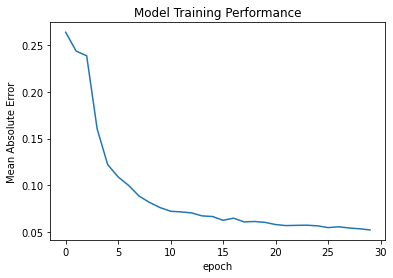

In [15]:
plt.plot(history_handbuilt.history['mean_absolute_error'])
plt.title('Model Training Performance')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')

## Using The  Built-in Keras SimpleRNN Layer
- The previous example showed how to build a RNN by hand in Keras.  That exercise was just for educational purposes.
- Normally we'd use the SimpleRNN keras layer to build a RNN like this.

- The key thing to understand is that the SimpleRNN layer takes in a tensor of shape \[training_set_size,time_sequence_length,input_vector_length\] and outputs one of shape \[training_set_size, num_units\].  *Even though it looks like an ordinary single layer, when it executes, it is in fact internally executing the whole time loop of length time_sequence_length.*

<img src="./images/simplernn_layer_network.svg"  width="600">

- Notice how, in the above diagram, the SimpleRNN layer consumes a rank-3 tensor and spits out a rank-2 tensor?  All of the RNN looping behaviour is handled internally by the SimpleRNN layer.

- So let's start again with building this model using the Keras-layers way:

In [16]:
# Define Sequential model with 3 layers
model_keras_rnn = keras.Sequential(name="my_keras_rnn_network")
model_keras_rnn.add(layers.SimpleRNN(20, activation='tanh',input_shape=(time_sequence_length,input_vector_length,)))
model_keras_rnn.add(layers.Dense(output_vector_length))
model_keras_rnn.summary()

Model: "my_keras_rnn_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20)                440       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________


As before, this model consumes a tensor of shape \[training_set_size,time_sequence_length,input_vector_length\] and outputs one of shape \[training_set_size,output_vector_length\]


In [17]:
# Try putting a single input into the network
print(model_keras_rnn(x_train[0:1,:,:]))

tf.Tensor([[-0.87951535  0.39345455]], shape=(1, 2), dtype=float32)


- Next, we'll train it as usual:

In [18]:
model_keras_rnn.compile(
    optimizer=keras.optimizers.Adam(0.01),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()],
)

history_keras_rnn = model_keras_rnn.fit(
    x_train,
    y_train,
    batch_size=100,
    epochs=30
)

Epoch 1/30
100/100 [==============================] - 1s 1ms/step - loss: 0.1221 - mean_absolute_error: 0.2690
Epoch 2/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0482 - mean_absolute_error: 0.1686
Epoch 3/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0253 - mean_absolute_error: 0.1240

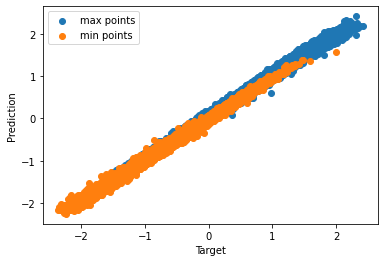

In [19]:
# Let's plot the model's current behaviour:
plt.scatter(y_train[:,0],model_keras_rnn(x_train).numpy()[:,0],label="max points")
plt.scatter(y_train[:,1],model_keras_rnn(x_train).numpy()[:,1],label="min points")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend()

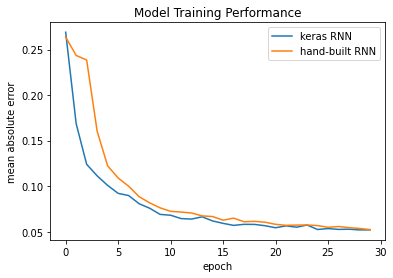

In [20]:
plt.plot(history_keras_rnn.history['mean_absolute_error'],label="keras RNN")
plt.plot(history_handbuilt.history['mean_absolute_error'],label="hand-built RNN")
plt.title('Model Training Performance')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend()

- Conclusion: We can see the SimpleRNN layer is behaving virtually identically to the hand-built RNN we made at the top of this page.

- Therefore if you understand the hand-built code above then you understand the Keras SimpleRNN Layer, and you understand the fundamentals of what a RNN is.

- If you don't understand this well, then ask me now!  :) 

## Summary

- We've seen what a RNN is and how to build one by hand.
- We've used the keras layer to build RNNs quickly

An important detail to remember is the rank-3 shape of the input tensor to a "SimpleRNN" layer, and how that layer will process the full time sequence embedded in that rank-3 tensor.

## To think about next...

**Questions to Answer:**

1. For this dataset, if you wanted a feed-forward neural network to solve this problem, how many inputs should that network have and how many outputs? **Answer:** TODO

2. If we lengthen the list of numbers in each time sequence, think about how the structure of the feed-forward NN will need changing compared to that of the RNN.  Hence which architecture is more flexible at coping with varying-length sequences better?  **Answer:** TODO

3. In this notebook, what will happen if we change time_sequence_length from 4 to say 60? 
    - **Try it** above - change the variable at the top of this notebook, and re-run everything.   
    - Performance should drop.  Why?  And what can we do to fix it?...